In [1]:
# Initializing
import numpy as np
import pandas as pd #
import optuna
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, r2_score

import warnings
warnings.filterwarnings("ignore")

optuna.logging.set_verbosity(optuna.logging.ERROR)

In [3]:
# Read CSV File and Display First 5 Rows
df = pd.read_csv('MiningProcess_Flotation_Plant_Database.csv')

single_comma_mask = df.apply(lambda x: x.str.count(',')).eq(1) # For valyes with only 1 comma, the comma is replaced with a period
df[single_comma_mask] = df[single_comma_mask].replace({',': '.'}, regex=True)

df[~single_comma_mask] = df[~single_comma_mask].replace({',': ''}, regex=True) # For values with more than 1 comma, the commas are deleted

df.head() 

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,55.2,16.98,3019.53,557.434,395.713,100.664,1.74,249.214,253.235,250.576,...,250.884,457.396,432.962,424.954,443.558,502.255,446.37,523.344,66.91,1.31
1,55.2,16.98,3024.41,563.965,397.383,100.672,1.74,249.719,250.532,250.862,...,248.994,451.891,429.56,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,55.2,16.98,3043.46,568.054,399.668,10.068,1.74,249.741,247.874,250.313,...,248.071,451.24,468.927,434.61,449.688,484.411,447.826,458.567,66.91,1.31
3,55.2,16.98,3047.36,568.665,397.939,100.689,1.74,249.917,254.487,250.049,...,251.147,452.441,458.165,442.865,446.21,471.411,437.69,427.669,66.91,1.31
4,55.2,16.98,3033.69,558.167,400.254,100.697,1.74,250.203,252.136,249.895,...,248.928,452.441,452.9,450.523,453.67,462.598,443.682,425.679,66.91,1.31


In [5]:
# Filtering target classes with less than 2 unique values
def filter_classes(df, min_samples=2):
    class_counts = df['% Silica Concentrate'].value_counts()
    filtered_labels = class_counts[class_counts >= min_samples].index
    filtered_df = df[df['% Silica Concentrate'].isin(filtered_labels)]
    return filtered_df
df_filtered = filter_classes(df)

In [7]:
# Splitting data into 80% training and 20% testing with stratification
X = df_filtered.iloc[:, :-1]  # Features
y = df_filtered['% Silica Concentrate']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
# Normalizing
sc = StandardScaler()
X_train_normalized = sc.fit_transform(X_train)
X_test_normalized = sc.transform(X_test)

In [11]:
scorer = make_scorer(r2_score)

In [13]:
# SVR
def objective_svr(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    C = trial.suggest_float('C', 1e-5, 1e5, log=True)
    epsilon = trial.suggest_float('epsilon', 0.01, 10.0, log=True)
    
    model = SVR(kernel=kernel, C=C, epsilon=epsilon)
    score = cross_val_score(model, X_train_normalized, y_train, cv=3, scoring=scorer)
    return score.mean()

study_svr = optuna.create_study(direction='maximize')
study_svr.optimize(objective_svr, n_trials=50)
print("Best parameters for SVR: ", study_svr.best_params)

best_svr = SVR(**study_svr.best_params)
best_svr.fit(X_train_normalized, y_train)
svr_r2 = r2_score(y_test, best_svr.predict(X_test_normalized))
print("SVR R2 Score:", svr_r2)

Best parameters for SVR:  {'kernel': 'rbf', 'C': 1.3834944081690639, 'epsilon': 0.010098592657741247}
SVR R2 Score: 0.9644107828199335


In [17]:
# MLP Regressor
def objective_mlp(trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 100)])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-1, log=True)
    
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, learning_rate_init=learning_rate_init, random_state=0, max_iter=1000)
    score = cross_val_score(model, X_train_normalized, y_train, n_jobs=-1, cv=3, scoring=scorer)
    return score.mean()

study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(objective_mlp, n_trials=50)
print("Best parameters for MLPRegressor: ", study_mlp.best_params)

best_mlp = MLPRegressor(**study_mlp.best_params, random_state=0, max_iter=1000)
best_mlp.fit(X_train_normalized, y_train)
mlp_r2 = r2_score(y_test, best_mlp.predict(X_test_normalized))
print("MLPRegressor R2 Score:", mlp_r2)

Best parameters for MLPRegressor:  {'hidden_layer_sizes': (100, 100), 'alpha': 0.09514093113017412, 'learning_rate_init': 0.024589324245734782}
MLPRegressor R2 Score: 0.9526797806526326


In [26]:
# Linear Regression
def objective_lr(trial):
    # No hyperparameters to tune for Linear Regression
    model = LinearRegression()
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3, scoring=scorer)
    return score.mean()

study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=50)
print("Best parameters for Linear Regression: ", study_lr.best_params)

best_lr = LinearRegression()
best_lr.fit(X_train, y_train)
lr_r2 = r2_score(y_test, best_lr.predict(X_test))
print("Linear Regression R2 Score:", lr_r2)

Best parameters for Linear Regression:  {}
Linear Regression R2 Score: 0.8191645718095352


In [19]:
# RandomForest Regressor
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    model = RandomForestRegressor(n_estimators=n_estimators, 
                                  max_depth=max_depth, 
                                  min_samples_split=min_samples_split, 
                                  min_samples_leaf=min_samples_leaf, 
                                  random_state=0, 
                                  n_jobs=-1)
    score = cross_val_score(model, X_train_normalized, y_train, n_jobs=-1, cv=3, scoring=scorer)
    return score.mean()

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)
print("Best parameters for RandomForestRegressor: ", study_rf.best_params)

best_rf = RandomForestRegressor(**study_rf.best_params, random_state=0, n_jobs=-1)
best_rf.fit(X_train_normalized, y_train)
rf_r2 = r2_score(y_test, best_rf.predict(X_test_normalized))
print("RandomForestRegressor R2 Score:", rf_r2)


Best parameters for RandomForestRegressor:  {'n_estimators': 161, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 9}
RandomForestRegressor R2 Score: 0.9975943295778432


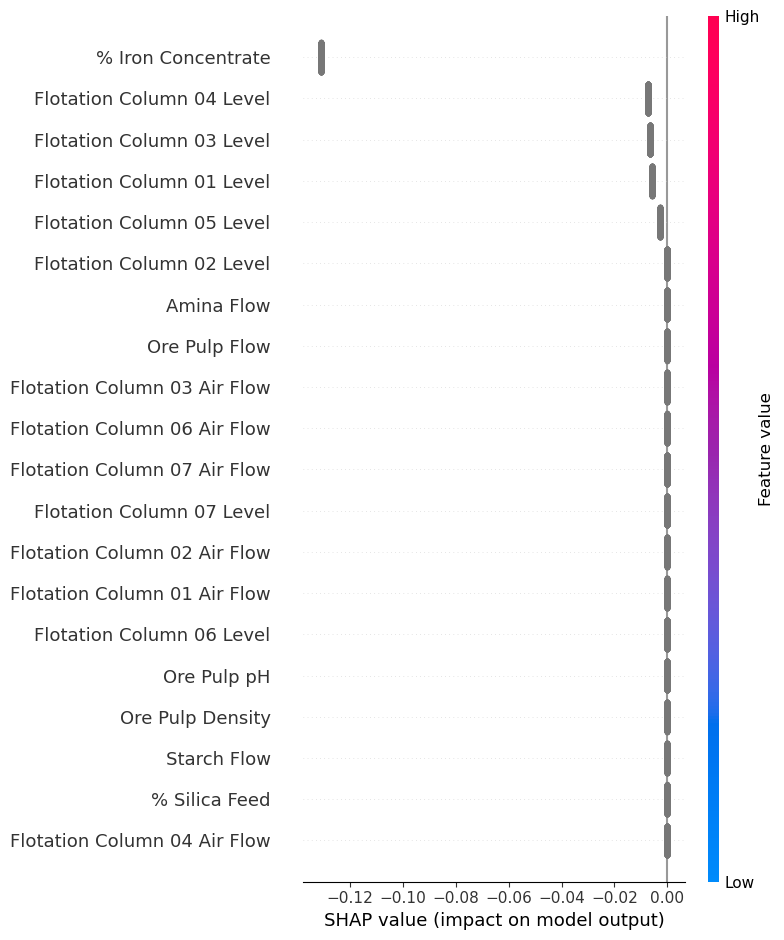

In [29]:
# Explainability Analysis on Random Forest Regressor using Tree Explainer
tree_explainer = shap.TreeExplainer(best_rf)
shap_values = tree_explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)